In [1]:
%config Completer.use_jedi = False

In [80]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
random.seed(0)

from sklearn.impute import SimpleImputer
import shap
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

plt.style.use("seaborn-whitegrid")
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["figure.figsize"] = 16, 8
import seaborn as sns
from scipy.stats import kstest

In [81]:
def explain(pipe,X):

    explainer = shap.Explainer(pipe.named_steps['model'])
    xx = pd.DataFrame(pipe[:-1].transform(X),columns=X.columns)
    shap_values = explainer(xx)

    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)

In [110]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
subm = pd.read_csv('data/sample_submission.csv')

In [111]:
data['train']=1
test['train']=0

In [112]:
df = data.append(test)

In [85]:
df = df.drop(columns='id')

In [86]:
df = pd.get_dummies(df,columns=['obs_day'])

In [87]:
# Not working
df['vaps_pres_temp'] = df['vap_pressure']/df['vap_temp']
#data['hour_sin'] = np.sin(2 * np.pi * data['obs_hour']/23.0)
#data['hour_cos'] = np.cos(2 * np.pi * data['obs_hour']/23.0)
df['vol'] = df['vap_temp']/df['vap_pressure']
df['vol_div'] = df['vap_temp']/df['vap_pressure_div']

# Inverse
df["vap_temp_inv"] = df["vap_temp"] ** -1
df["vap_pressure"] = df["vap_pressure"] ** -1
df["vap_enth"] = df["vap_enth"] ** -1
df["vap_pressure_div"] = df["vap_pressure_div"] ** -1
df["vap_motion"] = df["vap_motion"] ** -1
df['faucet_hole'] = df['faucet_hole']**-1

In [113]:
df

,id,obs_day,obs_hour,obs_minute,C_motion,fw_motion,faucet_hole,vap_pressure,vap_enth,vap_pressure_div,vap_motion,fw_enth,vap_temp,output_gen,train
0,a563699ca2a601c6ac64aa29986a00a90fb42b48741695...,Saturday,5.0,46.0,361.486145,2542.801078,0.666879,24.138243,2788.168701,25.448248,2543.177002,1270.066040,603.834106,930.271729,1
1,91ab3eb3bcf6c8c1c5fe2da9ba671aa5a48c7369d9a50f...,Saturday,18.0,NaN,197.064667,1454.458144,NaN,12.702796,NaN,13.405114,1454.421021,1095.314453,500.178772,473.562103,1
2,7128c51c554735d6c81862684ad6005ae12d2edbcd4644...,Saturday,3.0,51.0,356.869232,2458.671690,0.678685,NaN,2784.910889,NaN,2456.578369,1262.656982,603.529663,904.269897,1
3,c8144b52e4f63014de0a0d8e1c629bf0b05cb2696cfc23...,Saturday,13.0,NaN,239.267517,1628.127295,0.679137,15.378051,2881.876709,16.252741,1626.861328,1148.203857,593.649658,597.799194,1
4,88d15a5b2df6692f23d105ff1ae82ae026be00c9271eef...,Friday,11.0,13.0,NaN,2621.829401,0.676403,24.517698,2787.063232,NaN,2621.653564,1280.567383,602.601501,950.284973,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,ce52e6031c966ea3c88495428b0f27e772dacafdabe52e...,Saturday,11.0,25.0,236.904633,1741.410339,0.644819,17.264051,2928.930176,18.141627,1740.611816,1171.553711,598.504211,NaN,0
47996,5e4245cb0d071b5743f1224cbc8630b4946bcaab2f7072...,Saturday,13.0,NaN,233.311859,1639.089412,0.667020,15.753609,2885.263672,16.609934,1642.157104,1150.022949,588.658203,NaN,0
47997,1a04eacd2ed49266f5ee3893be37857db26245ea32a2c8...,Friday,10.0,17.0,364.628662,2596.038249,0.660052,24.933361,2787.292969,26.259435,2598.148926,1280.458618,602.522888,NaN,0
47998,d628a3e6f0eee1d1f4d4e80d3ddc2509cad26a70a06d29...,Friday,11.0,12.0,370.186768,2623.624449,NaN,24.584421,2786.311768,NaN,2620.279785,1280.452148,602.867676,NaN,0


In [96]:
# Might work
df['vol_pres'] = df['vap_pressure']/df['vap_enth']
df['vol_pres_div'] = df['vap_pressure_div']/df['vap_enth']

df['motion_times_vap'] = df['fw_motion'] * df['vap_pressure_div']
df['motion_by_vap'] = df['fw_motion'] / df['vap_pressure_div']
df['motion_by_vap_inv'] = (df['fw_motion'] / df['vap_pressure_div'])**-1

df['vap_dif'] = df['vap_pressure'] - df['vap_pressure_div']

# Machine Learning

In [97]:
data = df[df['train']==1]
test = df[df['train']==0]

In [98]:
X_tr, X_te, y_tr, y_te = train_test_split(
    data.drop(columns=["train", "output_gen"]), data["output_gen"],random_state=0
)

In [99]:
imp = SimpleImputer(strategy='mean')
#model = CatBoostRegressor(verbose=0,iterations=200)
model = Lasso()
pipe = Pipeline([('imputer',imp),('model',model)])

pipe.fit(X_tr,y_tr)

mean_squared_error(pipe.predict(X_te),y_te,squared=False)

37.619388400754495

In [100]:
imp = SimpleImputer()
model = CatBoostRegressor(verbose=0,iterations=200)

pipe = Pipeline([('imputer',imp),('model',model)])

pipe.fit(X_tr,y_tr)

mean_squared_error(pipe.predict(X_te),y_te,squared=False)

4.637131787507624

In [101]:
df.describe()

,obs_hour,obs_minute,C_motion,fw_motion,faucet_hole,vap_pressure,vap_enth,vap_pressure_div,vap_motion,fw_enth,...,vaps_pres_temp,vol,vol_div,vol_pres,vol_pres_div,motion_times_vap,motion_by_vap,motion_by_vap_inv,vap_dif,vap_temp_inv
count,106911.000000,106900.000000,106768.000000,106775.000000,106791.000000,106723.000000,106831.000000,106881.000000,106729.000000,106820.000000,...,95119.000000,95119.000000,95279.000000,95018.000000,95115.000000,95204.000000,95204.000000,95204.000000,95037.000000,106921.000000
mean,11.841934,29.383910,328.437893,2287.671366,0.670540,0.048888,0.000358,0.046338,0.000458,1230.790012,...,0.036664,28.531502,27.043513,136.935284,129.797612,100.399082,54718.953749,0.000023,0.002536,0.001697
std,6.031397,17.273325,83.174802,447.459667,0.011347,0.013925,0.000005,0.013206,0.000121,256.523135,...,0.008553,6.349548,6.018504,40.340877,38.250610,5.436726,20604.924531,0.000014,0.000723,0.000100
min,0.000000,0.000000,114.607033,1081.392319,0.602171,0.009156,0.000341,0.008687,0.000086,0.000000,...,0.019812,5.574756,5.280993,25.345822,24.023481,23.214308,10568.734780,0.000003,0.000449,0.001643
25%,7.000000,14.000000,319.348877,2244.559443,0.662273,0.041310,0.000356,0.039181,0.000391,1247.574402,...,0.036927,24.882303,23.583034,114.500925,108.517737,99.246652,55150.067973,0.000015,0.002126,0.001657
50%,12.000000,29.000000,350.073196,2461.669130,0.675265,0.042914,0.000359,0.040668,0.000406,1263.741150,...,0.038652,25.872079,24.518318,119.335273,113.101134,100.570204,60615.096990,0.000016,0.002247,0.001660
75%,17.000000,44.000000,361.913276,2552.906998,0.678519,0.044976,0.000361,0.042600,0.000430,1274.750061,...,0.040189,27.080463,25.632118,127.409670,120.467753,101.246089,65129.363691,0.000018,0.002400,0.001665
max,23.000000,59.000000,1698.141480,2932.372995,0.687786,0.107944,0.000371,0.102392,0.000922,5256.435548,...,0.179380,50.474277,47.905448,297.732984,282.415895,112.174442,334381.605102,0.000095,0.005620,0.002142


In [102]:

df['vap_pressure']

0        0.041428
1        0.078723
2             NaN
3        0.065028
4        0.040787
           ...   
47995    0.057924
47996    0.063478
47997    0.040107
47998    0.040676
47999    0.010333
Name: vap_pressure, Length: 120000, dtype: float64

<AxesSubplot:ylabel='Density'>

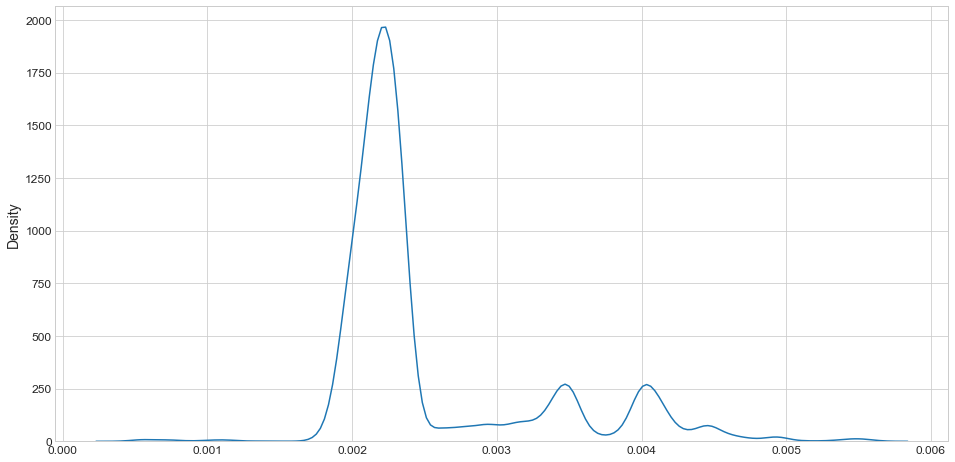

In [103]:
sns.kdeplot(df['vap_dif'].dropna().values)

<AxesSubplot:ylabel='Density'>

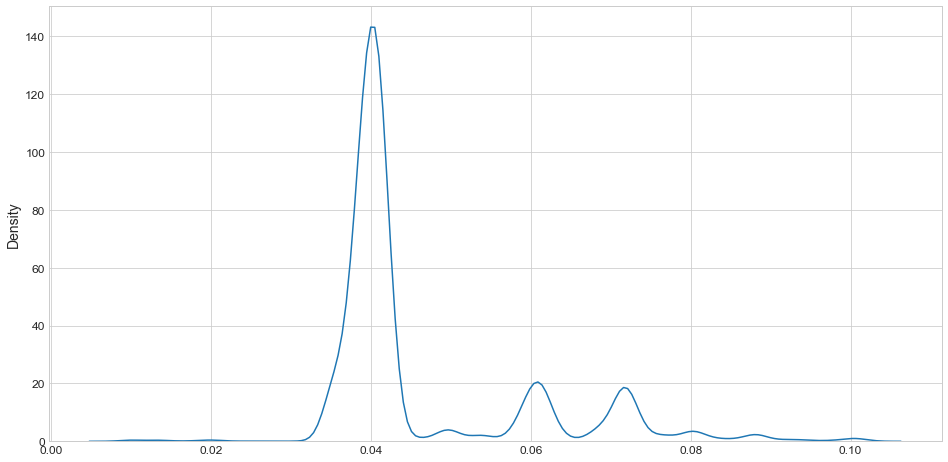

In [104]:
sns.kdeplot(df['vap_pressure_div'].dropna().values)

In [105]:
sns.kdeplot(df['vap_'].dropna().values)

KeyError: 'vap_'

In [ ]:
explain(pipe,X_tr)

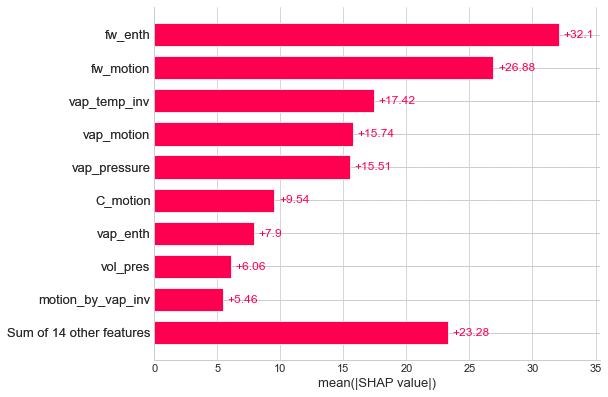

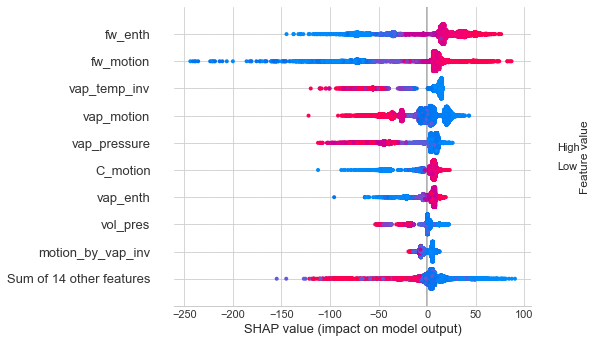

In [106]:
explain(pipe,X_te)

## Subm

In [107]:
test_subm = test.drop(columns=["train", "output_gen"])

In [108]:
tr = pd.DataFrame(pipe[:-1].transform(X_tr),columns=X_tr.columns)
te = pd.DataFrame(pipe[:-1].transform(test_subm),columns=test_subm.columns)


In [109]:
for col in tr.columns:
    ks = kstest(tr[col],te[col])
    if ks.pvalue<0.05:
        print('Pvalue:')
        print(col,ks.pvalue)
    if ks.statistic>0.05:
        print('K-S:')
        print(col,ks.statistic)
        


Pvalue:
vap_enth 0.014617226903008165
Pvalue:
motion_times_vap 0.032467349419180724


In [19]:
ss = pipe.predict(test_subm)

In [20]:
subm.output_gen = ss

In [21]:
kk

NameError: name 'kk' is not defined

In [22]:
subm.to_csv('subm/third.csv',index=False)